# GNN 기반 영화 추천 시스템
# V7a: Hyperparameter Tuning - Deeper GNN (layers: 2 → 3)
# V6 데이터 필터링 기반 + 더 깊은 propagation

In [1]:
import os
import pickle
import random
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import degree

from tqdm.notebook import tqdm

# 시각화 설정
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("=" * 60)
print("환경 설정")
print("=" * 60)
print(f"PyTorch 버전: {torch.__version__}")
print(f"CUDA 사용 가능: {torch.cuda.is_available()}")
print(f"MPS 사용 가능: {torch.backends.mps.is_available()}")
print("=" * 60)

환경 설정
PyTorch 버전: 2.9.0
CUDA 사용 가능: False
MPS 사용 가능: True


In [2]:
# 하이퍼파라미터 설정 (V7a - Deeper GNN)
CONFIG = {
    # Filtering 기준 (V6와 동일)
    'min_user_interactions': 30,
    'min_item_interactions': 10,
    'rating_threshold': None,
    
    # Split 비율 (V6와 동일)
    'train_ratio': 0.70,
    'valid_ratio': 0.15,
    'test_ratio': 0.15,
    
    # 모델 파라미터 (⭐ 핵심 변경!)
    'embedding_dim': 64,
    'n_layers': 3,        # V6: 2 → V7a: 3 (Deeper propagation)
    
    # 학습 파라미터 (V6와 동일)
    'learning_rate': 0.001,
    'weight_decay': 1e-4,
    'batch_size': 512,
    'epochs': 100,
    'patience': 20,
    'neg_ratio': 4,
    
    # 평가
    'top_k': 10,
    
    # 시스템
    'device': 'mps' if torch.backends.mps.is_available() else 'cpu',
    'seed': 42,
    
    # 경로
    'data_dir': '../data',
    'processed_dir': '../data/processed',
    'model_dir': '../models',
    'result_dir': '../results',
}

# 폴더 생성
for dir_path in [CONFIG['processed_dir'], CONFIG['model_dir'], CONFIG['result_dir']]:
    os.makedirs(dir_path, exist_ok=True)

# Random seed 고정
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
    if torch.backends.mps.is_available():
        torch.mps.manual_seed(seed)

set_seed(CONFIG['seed'])

print("=" * 60)
print("V7a 설정 완료! (Deeper GNN)")
print("=" * 60)
print(f"Device: {CONFIG['device']}")
print(f"\n⭐ V6 → V7a 변경사항:")
print(f"  Layers: 2 → 3 (더 깊은 graph propagation!)")
print(f"\n실험 가설:")
print(f"  V6에서 item degree가 24.6으로 증가")
print(f"  → Denser graph에서 3-layer propagation이 더 효과적일 것")
print(f"\n기타 설정 (V6와 동일):")
print(f"  Embedding dim: {CONFIG['embedding_dim']}")
print(f"  Learning rate: {CONFIG['learning_rate']}")
print(f"  Negative ratio: {CONFIG['neg_ratio']}")
print("=" * 60)
print("\n🎯 목표: Recall@10 > 8.5% (V6의 7.94% 대비 개선!)")
print("=" * 60)

V7a 설정 완료! (Deeper GNN)
Device: mps

⭐ V6 → V7a 변경사항:
  Layers: 2 → 3 (더 깊은 graph propagation!)

실험 가설:
  V6에서 item degree가 24.6으로 증가
  → Denser graph에서 3-layer propagation이 더 효과적일 것

기타 설정 (V6와 동일):
  Embedding dim: 64
  Learning rate: 0.001
  Negative ratio: 4

🎯 목표: Recall@10 > 8.5% (V6의 7.94% 대비 개선!)


## 데이터 로드 (V6 전처리 파일 사용)

In [3]:
# V6에서 전처리한 데이터 로드
print("=" * 60)
print("V6 전처리 데이터 로드")
print("=" * 60)

train_df = pd.read_csv(os.path.join(CONFIG['processed_dir'], 'train_split_v6.csv'))
valid_df = pd.read_csv(os.path.join(CONFIG['processed_dir'], 'valid_split_v6.csv'))
test_df = pd.read_csv(os.path.join(CONFIG['processed_dir'], 'test_split_v6.csv'))

with open(os.path.join(CONFIG['processed_dir'], 'id_mappings_v6.pkl'), 'rb') as f:
    mappings = pickle.load(f)

n_users = len(mappings['user_id_map'])
n_items = len(mappings['item_id_map'])

print(f"\n데이터 로드 완료!")
print(f"  Users: {n_users}")
print(f"  Items: {n_items}")
print(f"  Train: {len(train_df):,}")
print(f"  Valid: {len(valid_df):,}")
print(f"  Test:  {len(test_df):,}")
print("\n✅ V6와 동일한 데이터 사용 → 공정한 비교 가능")

V6 전처리 데이터 로드

데이터 로드 완료!
  Users: 529
  Items: 2283
  Train: 56,072
  Valid: 11,826
  Test:  12,572

✅ V6와 동일한 데이터 사용 → 공정한 비교 가능


## Graph 구성

In [4]:
# Graph 구성
print("=" * 60)
print("Graph 구성")
print("=" * 60)

def create_graph(df, n_users, n_items):
    """User-Item Bipartite Graph 생성"""
    user_ids = df['user_id'].values
    item_ids = df['item_id'].values + n_users
    
    edge_index = torch.tensor([
        np.concatenate([user_ids, item_ids]),
        np.concatenate([item_ids, user_ids])
    ], dtype=torch.long)
    
    print(f"Node 수: {n_users + n_items} (User: {n_users}, Item: {n_items})")
    print(f"Edge 수: {edge_index.shape[1]:,} (양방향)")
    
    return edge_index

print("\n[1] Train Graph (학습용)")
train_edge_index = create_graph(train_df, n_users, n_items)

print("\n[2] Train+Valid Graph (Test 평가용)")
train_valid_df = pd.concat([train_df, valid_df])
train_valid_edge_index = create_graph(train_valid_df, n_users, n_items)

print("\n✅ Graph 생성 완료!")

Graph 구성

[1] Train Graph (학습용)
Node 수: 2812 (User: 529, Item: 2283)
Edge 수: 112,144 (양방향)

[2] Train+Valid Graph (Test 평가용)
Node 수: 2812 (User: 529, Item: 2283)
Edge 수: 135,796 (양방향)

✅ Graph 생성 완료!


/var/folders/mh/1w84fr7s5kxcwc2l24qrjjwc0000gn/T/ipykernel_4526/3903611053.py:11: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:256.)
  edge_index = torch.tensor([


## 모델 정의

In [5]:
# Negative Sampling
def create_user_item_dict(df):
    """User별로 상호작용한 item 집합 생성"""
    user_items = defaultdict(set)
    for _, row in df.iterrows():
        user_items[row['user_id']].add(row['item_id'])
    return user_items

def negative_sampling(df, user_items_dict, n_items, neg_ratio=1):
    """Random negative sampling"""
    pos_users = df['user_id'].values
    pos_items = df['item_id'].values
    
    neg_users = []
    neg_items = []
    
    for user_id, pos_item in zip(pos_users, pos_items):
        user_pos_items = user_items_dict[user_id]
        
        for _ in range(neg_ratio):
            while True:
                neg_item = random.randint(0, n_items - 1)
                if neg_item not in user_pos_items:
                    break
            
            neg_users.append(user_id)
            neg_items.append(neg_item)
    
    return np.array(neg_users), np.array(neg_items)

train_user_items = create_user_item_dict(train_df)
train_valid_user_items = create_user_item_dict(train_valid_df)

print("User-item dictionary 생성 완료!")

User-item dictionary 생성 완료!


In [6]:
# LightGCN 모델 (V6와 동일)
class LightGCNConv(MessagePassing):
    """LightGCN Convolution Layer"""
    def __init__(self):
        super().__init__(aggr='add')
    
    def forward(self, x, edge_index):
        row, col = edge_index
        deg = degree(col, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]
        
        return self.propagate(edge_index, x=x, norm=norm)
    
    def message(self, x_j, norm):
        return norm.view(-1, 1) * x_j

class LightGCN(nn.Module):
    """LightGCN for Recommendation"""
    def __init__(self, n_users, n_items, embedding_dim=64, n_layers=2):
        super().__init__()
        
        self.n_users = n_users
        self.n_items = n_items
        self.embedding_dim = embedding_dim
        self.n_layers = n_layers
        
        self.user_embedding = nn.Embedding(n_users, embedding_dim)
        self.item_embedding = nn.Embedding(n_items, embedding_dim)
        
        nn.init.normal_(self.user_embedding.weight, std=0.1)
        nn.init.normal_(self.item_embedding.weight, std=0.1)
        
        self.convs = nn.ModuleList([LightGCNConv() for _ in range(n_layers)])
    
    def forward(self, edge_index):
        user_emb = self.user_embedding.weight
        item_emb = self.item_embedding.weight
        all_emb = torch.cat([user_emb, item_emb], dim=0)
        
        embs = [all_emb]
        
        for conv in self.convs:
            all_emb = conv(all_emb, edge_index)
            embs.append(all_emb)
        
        final_emb = torch.stack(embs, dim=0).mean(dim=0)
        
        user_final = final_emb[:self.n_users]
        item_final = final_emb[self.n_users:]
        
        return user_final, item_final
    
    def predict(self, users, items, edge_index):
        user_emb, item_emb = self.forward(edge_index)
        user_emb = user_emb[users]
        item_emb = item_emb[items]
        scores = (user_emb * item_emb).sum(dim=1)
        return scores

print("LightGCN 모델 정의 완료!")

LightGCN 모델 정의 완료!


In [7]:
# BPR Loss
def bpr_loss(pos_scores, neg_scores, neg_ratio=1):
    """BPR Loss"""
    if neg_ratio > 1:
        batch_size = pos_scores.size(0)
        neg_scores = neg_scores.view(batch_size, neg_ratio)
        pos_scores_expanded = pos_scores.unsqueeze(1).expand_as(neg_scores)
        loss = -torch.log(torch.sigmoid(pos_scores_expanded - neg_scores) + 1e-10).mean()
    else:
        loss = -torch.log(torch.sigmoid(pos_scores - neg_scores) + 1e-10).mean()
    
    return loss

print("Loss 함수 정의 완료!")

Loss 함수 정의 완료!


In [8]:
# 평가 함수
def evaluate_model(model, edge_index, eval_df, user_items_dict, n_items, k=10, device='cpu'):
    """모델 평가: Precision@K, Recall@K, NDCG@K"""
    model.eval()
    
    with torch.no_grad():
        user_emb, item_emb = model(edge_index.to(device))
        
        precisions, recalls, ndcgs = [], [], []
        
        for user_id, group in eval_df.groupby('user_id'):
            true_items = set(group['item_id'].values)
            exclude_items = user_items_dict[user_id]
            
            user_emb_single = user_emb[user_id].unsqueeze(0)
            scores = torch.matmul(user_emb_single, item_emb.t()).squeeze()
            
            scores_np = scores.cpu().numpy()
            for item_id in exclude_items:
                scores_np[int(item_id)] = -np.inf
            
            top_k_items = np.argsort(scores_np)[-k:][::-1]
            
            hits = len(set(top_k_items) & true_items)
            
            precision = hits / k
            recall = hits / len(true_items) if len(true_items) > 0 else 0
            
            dcg = sum([1 / np.log2(i + 2) for i, item in enumerate(top_k_items) if item in true_items])
            idcg = sum([1 / np.log2(i + 2) for i in range(min(len(true_items), k))])
            ndcg = dcg / idcg if idcg > 0 else 0
            
            precisions.append(precision)
            recalls.append(recall)
            ndcgs.append(ndcg)
    
    return {
        f'precision@{k}': np.mean(precisions),
        f'recall@{k}': np.mean(recalls),
        f'ndcg@{k}': np.mean(ndcgs),
    }

print("평가 함수 정의 완료!")

평가 함수 정의 완료!


In [9]:
# Training 함수
def train_one_epoch(model, edge_index, train_df, user_items_dict, n_items, 
                    optimizer, batch_size, neg_ratio, device):
    """1 epoch training"""
    model.train()
    
    train_df_shuffled = train_df.sample(frac=1).reset_index(drop=True)
    
    total_loss = 0
    n_batches = 0
    
    for start_idx in range(0, len(train_df_shuffled), batch_size):
        end_idx = min(start_idx + batch_size, len(train_df_shuffled))
        batch_df = train_df_shuffled.iloc[start_idx:end_idx]
        
        pos_users = torch.tensor(batch_df['user_id'].values, dtype=torch.long).to(device)
        pos_items = torch.tensor(batch_df['item_id'].values, dtype=torch.long).to(device)
        
        neg_users_np, neg_items_np = negative_sampling(
            batch_df, user_items_dict, n_items, neg_ratio
        )
        neg_users = torch.tensor(neg_users_np, dtype=torch.long).to(device)
        neg_items = torch.tensor(neg_items_np, dtype=torch.long).to(device)
        
        pos_scores = model.predict(pos_users, pos_items, edge_index.to(device))
        neg_scores = model.predict(neg_users, neg_items, edge_index.to(device))
        
        loss = bpr_loss(pos_scores, neg_scores, neg_ratio)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        n_batches += 1
    
    return total_loss / n_batches

print("Training 함수 정의 완료!")

Training 함수 정의 완료!


## Training

In [10]:
# 메인 Training Loop (V7a)
model = LightGCN(
    n_users=n_users,
    n_items=n_items,
    embedding_dim=CONFIG['embedding_dim'],
    n_layers=CONFIG['n_layers']  # V7a: 3 layers!
).to(CONFIG['device'])

optimizer = torch.optim.Adam(
    model.parameters(), 
    lr=CONFIG['learning_rate'],
    weight_decay=CONFIG['weight_decay']
)

history = {
    'train_loss': [],
    'valid_precision': [],
    'valid_recall': [],
    'valid_ndcg': [],
}

best_recall = 0
patience_counter = 0

print("=" * 60)
print("Training 시작 (V7a - Deeper GNN)")
print("=" * 60)
print(f"Model: LightGCN")
print(f"  - Users: {n_users}, Items: {n_items}")
print(f"  - Embedding dim: {CONFIG['embedding_dim']}")
print(f"  - ⭐ Layers: {CONFIG['n_layers']} (V6: 2 → V7a: 3)")
total_params = sum(p.numel() for p in model.parameters())
print(f"  - Total params: {total_params:,}")
print(f"  - Train samples: {len(train_df):,}")
print(f"  - Params/Data ratio: {total_params/len(train_df):.2f}x")
print(f"\nDevice: {CONFIG['device']}")
print(f"Learning rate: {CONFIG['learning_rate']}")
print(f"Negative ratio: {CONFIG['neg_ratio']}")
print("=" * 60)

for epoch in range(CONFIG['epochs']):
    train_loss = train_one_epoch(
        model, train_edge_index, train_df, train_user_items,
        n_items, optimizer, CONFIG['batch_size'], 
        CONFIG['neg_ratio'], CONFIG['device']
    )
    
    val_metrics = evaluate_model(
        model, train_edge_index, valid_df, train_user_items,
        n_items, k=CONFIG['top_k'], device=CONFIG['device']
    )
    
    history['train_loss'].append(train_loss)
    history['valid_precision'].append(val_metrics[f'precision@{CONFIG["top_k"]}'])
    history['valid_recall'].append(val_metrics[f'recall@{CONFIG["top_k"]}'])
    history['valid_ndcg'].append(val_metrics[f'ndcg@{CONFIG["top_k"]}'])
    
    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"Epoch {epoch+1:3d}/{CONFIG['epochs']} | "
              f"Loss: {train_loss:.4f} | "
              f"P@{CONFIG['top_k']}: {val_metrics[f'precision@{CONFIG["top_k"]}']:.4f} | "
              f"R@{CONFIG['top_k']}: {val_metrics[f'recall@{CONFIG["top_k"]}']:.4f} | "
              f"NDCG@{CONFIG['top_k']}: {val_metrics[f'ndcg@{CONFIG["top_k"]}']:.4f}")
    
    current_recall = val_metrics[f'recall@{CONFIG["top_k"]}']
    if current_recall > best_recall:
        best_recall = current_recall
        patience_counter = 0
        torch.save(model.state_dict(), 
                   os.path.join(CONFIG['model_dir'], 'lightgcn_v7a_best.pth'))
    else:
        patience_counter += 1
    
    if patience_counter >= CONFIG['patience']:
        print(f"\nEarly stopping at epoch {epoch+1}")
        break

print("=" * 60)
print(f"Training 완료! (V7a)")
print(f"Best Recall@{CONFIG['top_k']}: {best_recall:.4f}")
print("=" * 60)

Training 시작 (V7a - Deeper GNN)
Model: LightGCN
  - Users: 529, Items: 2283
  - Embedding dim: 64
  - ⭐ Layers: 3 (V6: 2 → V7a: 3)
  - Total params: 179,968
  - Train samples: 56,072
  - Params/Data ratio: 3.21x

Device: mps
Learning rate: 0.001
Negative ratio: 4
Epoch   1/100 | Loss: 0.6920 | P@10: 0.1068 | R@10: 0.0604 | NDCG@10: 0.1185
Epoch   5/100 | Loss: 0.5556 | P@10: 0.1127 | R@10: 0.0619 | NDCG@10: 0.1225
Epoch  10/100 | Loss: 0.5544 | P@10: 0.1142 | R@10: 0.0618 | NDCG@10: 0.1236
Epoch  15/100 | Loss: 0.5538 | P@10: 0.1115 | R@10: 0.0600 | NDCG@10: 0.1205
Epoch  20/100 | Loss: 0.5533 | P@10: 0.1117 | R@10: 0.0604 | NDCG@10: 0.1208
Epoch  25/100 | Loss: 0.5538 | P@10: 0.1142 | R@10: 0.0636 | NDCG@10: 0.1227

Early stopping at epoch 28
Training 완료! (V7a)
Best Recall@10: 0.0639


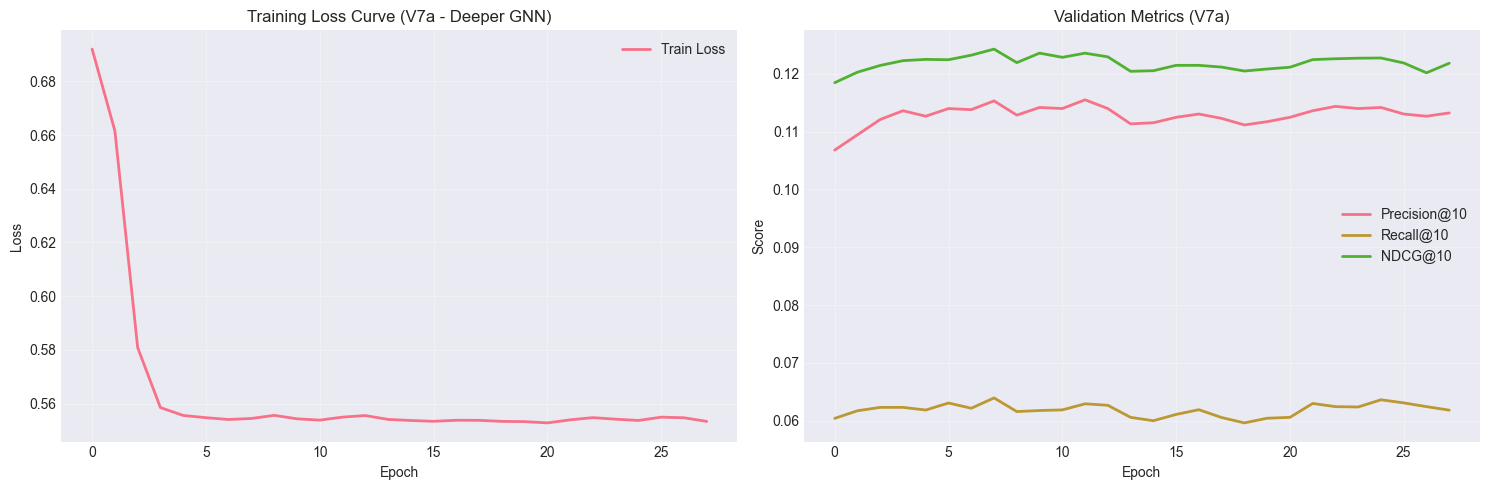

In [11]:
# Training 결과 시각화
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(history['train_loss'], label='Train Loss', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss Curve (V7a - Deeper GNN)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history['valid_precision'], label=f'Precision@{CONFIG["top_k"]}', linewidth=2)
axes[1].plot(history['valid_recall'], label=f'Recall@{CONFIG["top_k"]}', linewidth=2)
axes[1].plot(history['valid_ndcg'], label=f'NDCG@{CONFIG["top_k"]}', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Score')
axes[1].set_title('Validation Metrics (V7a)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(CONFIG['result_dir'], 'training_curves_v7a.png'), dpi=300, bbox_inches='tight')
plt.show()

## Test Set 평가

In [12]:
# Test Set 평가
model.load_state_dict(torch.load(os.path.join(CONFIG['model_dir'], 'lightgcn_v7a_best.pth')))

print("=" * 60)
print("Test Set 평가 (V7a - Deeper GNN)")
print("=" * 60)

v7a_results = {}

for k in [5, 10, 20]:
    test_metrics = evaluate_model(
        model, 
        train_valid_edge_index,
        test_df, 
        train_valid_user_items,
        n_items, 
        k=k, 
        device=CONFIG['device']
    )
    
    v7a_results[k] = test_metrics
    
    print(f"\nTop-{k} 추천:")
    print(f"  Precision@{k}: {test_metrics[f'precision@{k}']:.4f}")
    print(f"  Recall@{k}:    {test_metrics[f'recall@{k}']:.4f}")
    print(f"  NDCG@{k}:      {test_metrics[f'ndcg@{k}']:.4f}")

print("=" * 60)

Test Set 평가 (V7a - Deeper GNN)

Top-5 추천:
  Precision@5: 0.1694
  Recall@5:    0.0405
  NDCG@5:      0.1782

Top-10 추천:
  Precision@10: 0.1459
  Recall@10:    0.0669
  NDCG@10:      0.1638

Top-20 추천:
  Precision@20: 0.1212
  Recall@20:    0.1084
  NDCG@20:      0.1594


## V7a vs V6 비교

In [13]:
print("=" * 60)
print("V7a vs V6 결과 비교")
print("=" * 60)

# V6 결과 (실행 결과에서 가져옴)
v6_results = {
    10: {'precision@10': 0.1633, 'recall@10': 0.0794, 'ndcg@10': 0.1818}
}

print("\n핵심 변경사항:")
print(f"  V6: n_layers=2")
print(f"  V7a: n_layers=3 (Deeper propagation)")

print("\nTest Set 성능 (Recall@10):")
print(f"  V6:  {v6_results[10]['recall@10']:.4f} (7.94%)")
print(f"  V7a: {v7a_results[10]['recall@10']:.4f} ({v7a_results[10]['recall@10']*100:.2f}%)")

improvement = (v7a_results[10]['recall@10'] - v6_results[10]['recall@10']) / v6_results[10]['recall@10'] * 100
print(f"  변화: {improvement:+.1f}%")

print("\n전체 지표 비교 (Top-10):")
for metric in ['precision@10', 'recall@10', 'ndcg@10']:
    v6_val = v6_results[10][metric]
    v7a_val = v7a_results[10][metric]
    change = (v7a_val - v6_val) / v6_val * 100
    print(f"  {metric:15s}: V6={v6_val:.4f}, V7a={v7a_val:.4f} ({change:+.1f}%)")

print("\n" + "=" * 60)
print("실험 결과 해석:")
if improvement > 5:
    print("✅ 성공! Deeper GNN이 효과적")
    print("   → V7b(lower LR) 또는 V7c(larger emb)도 시도 권장")
elif improvement > 0:
    print("⚠️  소폭 개선. 의미 있는 개선은 아님")
    print("   → V8 Loss function 개선으로 넘어가는 것 권장")
else:
    print("❌ 성능 하락. Deeper GNN이 오히려 역효과")
    print("   → V6의 2-layer가 최적. V8로 넘어가기")
print("=" * 60)

V7a vs V6 결과 비교

핵심 변경사항:
  V6: n_layers=2
  V7a: n_layers=3 (Deeper propagation)

Test Set 성능 (Recall@10):
  V6:  0.0794 (7.94%)
  V7a: 0.0669 (6.69%)
  변화: -15.7%

전체 지표 비교 (Top-10):
  precision@10   : V6=0.1633, V7a=0.1459 (-10.6%)
  recall@10      : V6=0.0794, V7a=0.0669 (-15.7%)
  ndcg@10        : V6=0.1818, V7a=0.1638 (-9.9%)

실험 결과 해석:
❌ 성능 하락. Deeper GNN이 오히려 역효과
   → V6의 2-layer가 최적. V8로 넘어가기
